In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle 
import numpy as np
import pandas as pd
import torch
import os
from timeit import default_timer as timer

from sklearn import manifold, decomposition, neighbors
from sklearn.manifold.t_sne import trustworthiness
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [2]:
from core.SimpleConvNet import SimpleConvNet
from core.GraphConvNet2 import GraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph
from util.plot_embedding import plot_embedding, plot_embedding_subplot
from util.mnist_data_loader import get_train_set, get_test_set
from util.evaluation_metrics import evaluate_net_metrics, evaluate_embedding_metrics
from core.DimReduction import DimReduction

In [3]:
if torch.cuda.is_available():
    print('cuda available')
    device = 'gpu'
else:
    print('cuda not available')
    device = 'cpu'

cuda not available


In [4]:
net_parameters = {}
net_parameters['n_components'] = 2
net_parameters['D'] = 784 # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 10 # number of hidden layers
net_parameters['n_channels'] = 1
net_parameters['n_units_1'] = net_parameters['n_units_2'] = net_parameters['H']

In [5]:
filename = 'data/set_100_mnist_spectral_size_200_500.pkl'
with open(filename, 'rb') as f:
    [all_test_data] = pickle.load(f)

In [6]:
# Loss functions
def l2_norm(v):
    return np.sqrt(np.sum(np.square(v), axis=1, dtype=np.float64))

def pairwise_loss_function_1(y_true, y_pred, W):
    pairwise_loss_1 = mean_squared_error(y_true[W.row,:], y_true[W.col,:])
    pairwise_loss_2 = mean_squared_error(y_pred[W.row,:], y_pred[W.col,:])
    return np.square(pairwise_loss_1 - pairwise_loss_2)

def pairwise_loss_function_2(y_true, y_pred, W):
    pairwise_loss_1 = l2_norm(y_true[W.row,:] - y_true[W.col,:])
    pairwise_loss_2 = l2_norm(y_pred[W.row,:] - y_pred[W.col,:])
    return np.average(np.square(pairwise_loss_1 - pairwise_loss_2))

In [23]:
# Test all embeddings
methods = ['pca', 'spectral', 'tsne', 'isomap', 'lle', 'mds']
#methods = ['pca', 'spectral']
n_methods = len(methods)
all_trust = np.zeros((n_methods, ))
all_one_nn = np.zeros((n_methods, ))
all_time = np.zeros((n_methods, ))

for i, m in enumerate(methods):
    all_trust[i], all_one_nn[i], all_time[i] = evaluate_embedding_metrics(all_test_data, m)

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [26]:
comparison_table = {
    'Methods': methods,
    'Trustworthy score': all_trust,
    '1-NN generalisation accuracy': all_one_nn,
    'Average time to compute (s)': all_time
}
df = pd.DataFrame.from_dict(comparison_table)
df

,Methods,Trustworthy score,1-NN generalisation error,Average time to compute (s)
0,pca,0.701406,0.715661,0.003190
1,spectral,0.758252,0.552433,0.188213
2,tsne,0.955044,0.180229,6.650957
3,isomap,0.753734,0.623042,0.250813
4,lle,0.646439,0.721422,0.281585
5,mds,0.698733,0.711190,0.172736


## Evaluate trained nets

In [114]:
# Simple conv net
net = SimpleConvNet(net_parameters)
root = 'results/mnist_spectral1/'
filename = root + 'conv_net5.pkl'
checkpoint = torch.load(filename, map_location=device)
net.load_state_dict(checkpoint['state_dict'])

trustworthiness, one_nn, time_elapsed = evaluate_net_metrics(all_test_data, net)
print("Trustworthy score = {:.4f}".format(trustworthiness))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

Similarity loss = 0.0709895799395694
Trustworthy score = 0.5501872305425336
1-NN generalisation error = 0.8476193517441856
Average time to compute (s) = 0.7939383930801704


In [7]:
# Graph net
net = GraphConvNet2(net_parameters)
root = 'results/mnist_preprocessed_tsne1/'
filename = root + 'graph_net5.pkl'
checkpoint = torch.load(filename, map_location=device)
net.load_state_dict(checkpoint['state_dict'])

trustworthiness, one_nn, time_elapsed = evaluate_net_metrics(all_test_data, net)
print("Trustworthy score = {:.4f}".format(trustworthiness))
print("1-NN generalisation accuracy = {:.4f}".format(one_nn))
print("Average time to compute (s) = {:.2f}".format(time_elapsed))

Trustworthy score = 0.8717
1-NN generalisation accuracy = 0.7808
Average time to compute (s) = 0.37


## Create visualisation

In [12]:
test_net_1 = GraphConvNet2(net_parameters)
root = 'results/mnist_tsne1/'
filename = root + 'graph_net5.pkl'
checkpoint = torch.load(filename, map_location=device)
test_net_1.load_state_dict(checkpoint['state_dict'])

In [13]:
test_net_2 = GraphConvNet2(net_parameters)
root = 'results/mnist_preprocessed_tsne1/'
filename = root + 'graph_net5.pkl'
checkpoint = torch.load(filename, map_location=device)
test_net_2.load_state_dict(checkpoint['state_dict'])

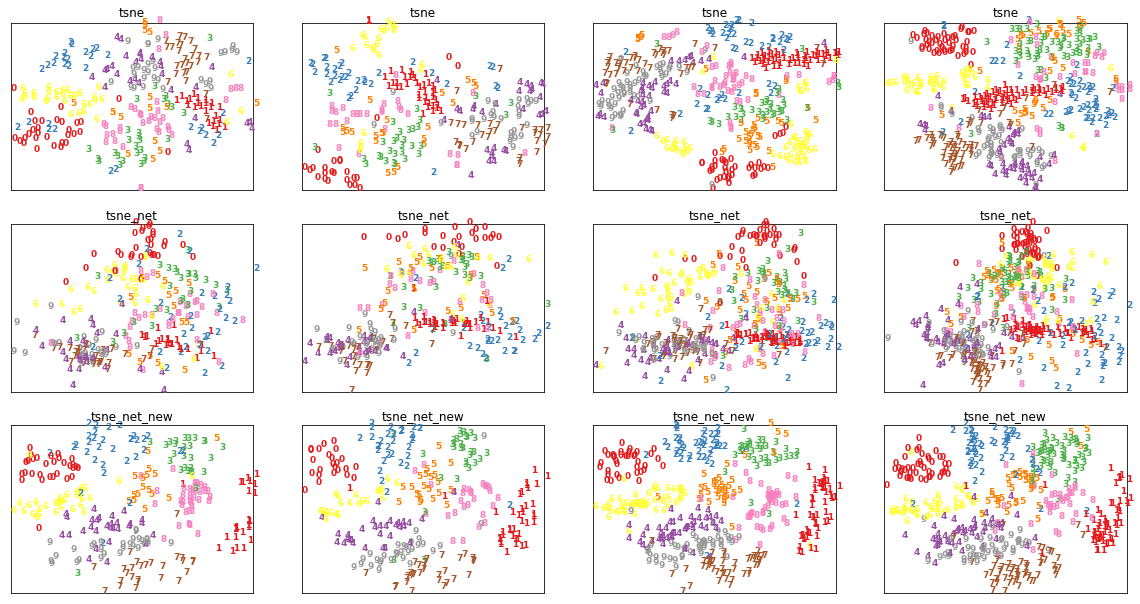

In [14]:
f, axarr = plt.subplots(3, 4, sharex='col', sharey='row', figsize=(20, 10.5))
dim_red = DimReduction(n_components=2)

for i in range(4):
    G = all_test_data[i]
    labels = [int(l) for l in G.labels]
    X = G.data.view(G.data.shape[0], -1).numpy()
    
    # Spectral
    X_emb1 = dim_red.fit_transform(X, 'tsne', labels)
    plot_embedding_subplot(axarr[0,i], X_emb1, labels=labels, title='tsne')
    
    # Spectral net
    y_pred = test_net_1.forward(G).detach().numpy()
    plot_embedding_subplot(axarr[1,i], y_pred, labels=labels, title='tsne_net')
    
#     # tsne
#     X_emb2 = dim_red.fit_transform(X, 'oracle_shuffle', labels)
#     plot_embedding_subplot(axarr[2,i], X_emb2, labels=labels, title='oracle_shuffle')
    
    # tsne net
    y_pred = test_net_2.forward(G).detach().numpy()
    plot_embedding_subplot(axarr[2,i], y_pred, labels=labels, title='tsne_net_new')
    